## 导入数据

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns

In [27]:
#读取数据并把date_account_created转换为datetime类型
basic_path = r"D:\github\数据集\Airbnb产品"
train_users_df = pd.read_csv(basic_path + r'\train_users.csv',parse_dates=['date_account_created'])
sessions_df = pd.read_csv(basic_path + r'\sessions.csv')
print(train_users_df.head())

           id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app 

## 数据清洗
### 数据描述性统计
缺失值

In [28]:
train_users_df.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [29]:
sessions_df.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [30]:
train_users_df.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


<AxesSubplot:>

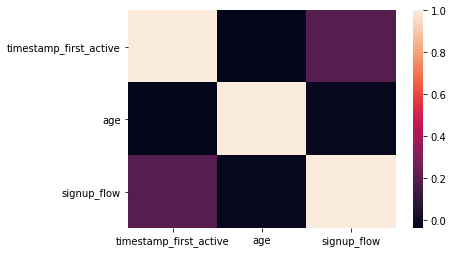

In [31]:
corr = train_users_df.corr()
sns.heatmap(corr)

## 数据分析

年龄最大值为2014，显然与实际不符，猜测把出生年当做年龄填入，年龄数据小于0大于100的数据修改为 -1,转换数据为int型，方便后续分类统计。

In [6]:
train_users_df.loc[(pd.isnull(train_users_df['age']))|(train_users_df['age']>100),'age']= -1
train_users_df['age'] = train_users_df['age'].astype('int')
print(train_users_df['age'])

0         -1
1         38
2         56
3         42
4         41
          ..
213446    32
213447    -1
213448    32
213449    -1
213450    -1
Name: age, Length: 213451, dtype: int32


In [7]:
#根据id去重，如果重复保留第一条数据
train_users_df = train_users_df.drop_duplicates(subset=['id'],keep='first')

用户画像分析


1.性别比例判断
表中 gender 存在三种分类：'male'，'female'及'unknown'，处理时将'unknown'

这一种情况排除在外，得到相关数据量情况：

In [8]:
gender_df = train_users_df[(train_users_df['gender']=='FEMALE')|(train_users_df['gender']== 'MALE')].groupby(by = 'gender').size()
print(gender_df)

gender
FEMALE    63041
MALE      54440
dtype: int64


2.年龄分布统计

In [9]:
def change_age(age):
    if age >0 and age <=20:
        return "20岁以下"
    elif age >20 and age <=30:
        return "20到30岁"
    elif age >30 and age <=40:
        return "30到40岁"
    elif age >40 and age <=50:
        return "40到50岁"
    elif age >50 and age <=100:
        return "50岁以上"
    


In [10]:
age_df = train_users_df.copy()
age_df['age'] = age_df["age"].apply(lambda x:change_age(x))
age_df = age_df.groupby("age").size()
print(age_df)

age
20到30岁    41633
20岁以下      2469
30到40岁    44212
40到50岁    18831
50岁以上     15971
dtype: int64


3.使用语言分布统计

In [11]:
#按照使用语言分类统计，并按照数量降序排列
language_df = train_users_df.groupby('language').size().sort_values(ascending=False)
print(language_df)

language
en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
dtype: int64


4.国家目的地

In [12]:
#过滤无数据，按照目标国家统计，并降序排列
country_df = train_users_df[train_users_df['country_destination'] != 'NDF'].groupby('country_destination').size().sort_values(ascending=False)
print(country_df)

country_destination
US       62376
other    10094
FR        5023
IT        2835
GB        2324
ES        2249
CA        1428
DE        1061
NL         762
AU         539
PT         217
dtype: int64


5.用户来源

In [13]:
#用户来源
sign_app_df = train_users_df[train_users_df['signup_app'] != 'NDF'].groupby('signup_app').size().sort_values(ascending=False)
print(sign_app_df)

signup_app
Web        182717
iOS         19019
Moweb        6261
Android      5454
dtype: int64


In [14]:
#web端访问来源
web_device_type_df = train_users_df[train_users_df['signup_app'] == 'Web'].groupby('first_device_type').size().sort_values(ascending=False)
print(web_device_type_df)

first_device_type
Mac Desktop           86839
Windows Desktop       70887
iPad                  13033
Other/Unknown          4773
iPhone                 4050
Desktop (Other)        1145
Android Tablet         1096
Android Phone           842
SmartPhone (Other)       52
dtype: int64


In [15]:
#新用户量随时间的变化
train_users_df['year_month'] = train_users_df['date_account_created'].apply(lambda x : x.strftime('%Y-%m'))
account_crea_df = train_users_df.groupby("year_month").size()
print(account_crea_df)

year_month
2010-01       61
2010-02      102
2010-03      163
2010-04      157
2010-05      227
2010-06      222
2010-07      307
2010-08      312
2010-09      371
2010-10      309
2010-11      286
2010-12      271
2011-01      316
2011-02      362
2011-03      491
2011-04      577
2011-05      744
2011-06      822
2011-07      993
2011-08     1454
2011-09     1864
2011-10     1477
2011-11     1386
2011-12     1289
2012-01     1589
2012-02     1789
2012-03     2192
2012-04     2589
2012-05     3325
2012-06     3867
2012-07     4582
2012-08     4476
2012-09     4035
2012-10     3828
2012-11     3706
2012-12     3484
2013-01     4418
2013-02     4362
2013-03     5421
2013-04     5855
2013-05     6721
2013-06     6765
2013-07     7950
2013-08     8369
2013-09     9125
2013-10     7862
2013-11     7751
2013-12     8361
2014-01    11111
2014-02     9967
2014-03    12058
2014-04    12689
2014-05    14895
2014-06    15746
dtype: int64


In [16]:
#预定人群渠道转化分析
af_prv_df = train_users_df[(train_users_df['date_first_booking'].notnull())].groupby(['affiliate_channel','affiliate_provider']).size().to_frame()
af_prv_df_1 = train_users_df.groupby(['affiliate_channel','affiliate_provider']).size().to_frame()
af_prv_df = af_prv_df.merge(af_prv_df_1, how='inner', left_index=True , right_index=True).reset_index()
af_prv_df.columns = ['channel','provider','渠道预定数量','渠道全部数量']
af_prv_df = af_prv_df[af_prv_df['渠道预定数量'] > 200]
af_prv_df['类型'] = af_prv_df['channel'] + '-' + af_prv_df['provider']
af_prv_df['占比'] = af_prv_df['渠道预定数量'] /af_prv_df['渠道全部数量']
print(af_prv_df.sort_values('占比',ascending=False))

          channel    provider  渠道预定数量  渠道全部数量                    类型        占比
30            seo      google    2739    5691            seo-google  0.481286
7           other  craigslist    1616    3471      other-craigslist  0.465572
29            seo    facebook     724    1677          seo-facebook  0.431723
5          direct      direct   59234  137426         direct-direct  0.431025
16      sem-brand      google   10705   25069      sem-brand-google  0.427021
11          other       other    1508    3656           other-other  0.412473
15      sem-brand        bing     375     950        sem-brand-bing  0.394737
23  sem-non-brand      google    6516   16947  sem-non-brand-google  0.384493
0             api       other    2785    8167             api-other  0.341006
13    remarketing      google     368    1094    remarketing-google  0.336380
21  sem-non-brand        bing     296     889    sem-non-brand-bing  0.332958
12          other   padmapper     252     768       other-padmap

In [17]:
#预定人群广告转化分析
first_aff_trac_df = train_users_df[(train_users_df['date_first_booking'].notnull())].groupby(['first_affiliate_tracked']).size().to_frame()
first_aff_trac_df_1 = train_users_df.groupby(['first_affiliate_tracked']).size().to_frame()
first_aff_trac_df = first_aff_trac_df.merge(first_aff_trac_df_1, how='inner', left_index=True , right_index=True).reset_index()
first_aff_trac_df.columns = ['营销广告来源','该来源预定人数','该来源全部人数']
#first_aff_trac_df = first_aff_trac_df[first_aff_trac_df['渠道预定数量'] > 200]
#first_aff_trac_df['类型'] = first_aff_trac_df['channel'] + '-' + first_aff_trac_df['provider']
first_aff_trac_df['占比'] = first_aff_trac_df['该来源预定人数'] /first_aff_trac_df['该来源全部人数']
first_aff_trac_df = first_aff_trac_df[first_aff_trac_df['营销广告来源'] != 'untracked']
print(first_aff_trac_df.sort_values('占比',ascending=False))

          营销广告来源  该来源预定人数  该来源全部人数        占比
2      marketing       63      139  0.453237
0         linked    20102    46287  0.434290
3            omg    16425    43982  0.373448
5  tracked-other     2290     6156  0.371995
4        product      542     1556  0.348329
1      local ops        9       34  0.264706


In [18]:
sessions_df = pd.read_csv(basic_path + r'\sessions.csv')

In [19]:
print(sessions_df.head())

      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                  NaN   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                  NaN   

       device_type  secs_elapsed  
0  Windows Desktop         319.0  
1  Windows Desktop       67753.0  
2  Windows Desktop         301.0  
3  Windows Desktop       22141.0  
4  Windows Desktop         435.0  


In [20]:
#总用户量
total_user_df = sessions_df.drop_duplicates('user_id')
print(total_user_df.shape[0])

135484


In [21]:
#注册用户数  ！！！注意count 和size的区别！！！
user_creat_df = total_user_df[['user_id','action_detail']].merge(train_users_df[['id','date_account_created']],how = 'left',left_on = 'user_id',right_on = 'id')
print(user_creat_df['date_account_created'].count())

73815


In [22]:
#定义用户在平台浏览次数超过10次即为活跃用户。活跃用户数为
n_df = sessions_df[['user_id','action_detail']].merge(train_users_df[['id','date_account_created']],how = 'left',left_on = 'user_id',right_on = 'id')
#n_df = n_df[n_df['date_account_created'].notnull()]
n_df = n_df.groupby('user_id').size().to_frame().reset_index()
n_df.columns = ['user_id','num']
n_df = n_df[n_df['num']>10]
print(n_df.shape[0])

111977


In [23]:
#注册用户中提交过订单信息的用户数
place_order_df = user_creat_df[user_creat_df['date_account_created'].notnull()]
place_order_df = sessions_df[sessions_df['action_detail'] == 'reservations'].groupby('user_id').size()
print(place_order_df.count())


10366


In [24]:
#注册用户中成功支付的用户数
place_order_df = user_creat_df[user_creat_df['date_account_created'].notnull()]
place_order_df = sessions_df[sessions_df['action_detail'] == 'payment_instruments'].groupby('user_id').size()
print(place_order_df.count())

9018


In [25]:
re_pay_user_df = place_order_df.to_frame().reset_index()
re_pay_user_df.columns = ["user_id","num"]
re_pay_user_df = re_pay_user_df[re_pay_user_df['num'] > 1]
print(re_pay_user_df.count())

user_id    4153
num        4153
dtype: int64
